In [1]:
import nibabel as nib
import scipy.io as sio
import numpy as np
import cbig_network_correspondence as cnc

### Data preparation

In [2]:
import matplotlib.pyplot as plt
plt.ioff()

In [3]:
mw_indices = sio.loadmat('./data/medialwall_verts.mat')['mw_verts'].squeeze() - 1 # convert to 0-index
print(mw_indices.shape)

(5572,)


In [4]:
def expand_to_full_fslr(data_trunc, mw_verts, zeros_init=True):
    """
    Expand cortex-only surface data (medial wall removed) to full fs_LR_32k space.

    Parameters
    ----------
    data_trunc : np.ndarray, shape (59412,)
        Data vector without medial wall (cortex-only).
    
    mw_verts : np.ndarray, shape (5572,)
        0-based indices of medial wall vertices in full fs_LR_32k space (length 64984).

    Returns
    -------
    data_full : np.ndarray, shape (64984,)
        Full-length fs_LR_32k data with 0s in medial wall locations.
    """
    assert data_trunc.shape[0] + mw_verts.shape[0] == 64984, "Mismatch in vertex counts"
    
    # Identify the vertices to keep (non-medial wall)
    all_indices = np.arange(64984)
    trunc2full = np.setdiff1d(all_indices, mw_verts)

    # Initialize full-length array with zeros or nan
    data_full = np.zeros((64984,)) if zeros_init else np.full((64984, ), np.nan)
    data_full[trunc2full] = data_trunc

    left_data, right_data = data_full[:32492], data_full[32492:]

    return left_data, right_data


In [5]:
prob_maps_dt = nib.load('./data/eLABE_Y2_Y3_templates_network_probability_maps.dtseries.nii')
prob_maps_fdata = prob_maps_dt.get_fdata()
print(prob_maps_dt.get_fdata().shape)
print(type(prob_maps_fdata))
print(prob_maps_fdata.max())
print(prob_maps_fdata.min())

n_maps, n_cortical_vertices = prob_maps_fdata.shape

(23, 59412)
<class 'numpy.memmap'>
1.0
0.0


In [6]:
fc_maps_dt = nib.load('./data/eLABE_Y2_Y3_templates_network_FC_maps.dtseries.nii')
fc_maps_fdata = fc_maps_dt.get_fdata()

In [7]:
above_03 = (prob_maps_fdata > 0.3).sum(axis=1)
above_05 = (prob_maps_fdata > 0.5).sum(axis=1)

for i in range(n_maps):
    print(f"ProbMap {i+1}: >0.3 = {above_03[i]}, >0.5 = {above_05[i]}")


ProbMap 1: >0.3 = 3181, >0.5 = 1781
ProbMap 2: >0.3 = 2149, >0.5 = 622
ProbMap 3: >0.3 = 1116, >0.5 = 314
ProbMap 4: >0.3 = 3205, >0.5 = 2182
ProbMap 5: >0.3 = 478, >0.5 = 353
ProbMap 6: >0.3 = 1077, >0.5 = 642
ProbMap 7: >0.3 = 4974, >0.5 = 3050
ProbMap 8: >0.3 = 2814, >0.5 = 943
ProbMap 9: >0.3 = 2897, >0.5 = 2107
ProbMap 10: >0.3 = 776, >0.5 = 169
ProbMap 11: >0.3 = 3401, >0.5 = 1994
ProbMap 12: >0.3 = 7163, >0.5 = 5186
ProbMap 13: >0.3 = 3224, >0.5 = 1357
ProbMap 14: >0.3 = 3480, >0.5 = 2881
ProbMap 15: >0.3 = 2371, >0.5 = 1252
ProbMap 16: >0.3 = 3384, >0.5 = 1388
ProbMap 17: >0.3 = 4220, >0.5 = 2276
ProbMap 18: >0.3 = 1572, >0.5 = 655
ProbMap 19: >0.3 = 1279, >0.5 = 791
ProbMap 20: >0.3 = 5958, >0.5 = 2319
ProbMap 21: >0.3 = 1342, >0.5 = 788
ProbMap 22: >0.3 = 703, >0.5 = 270
ProbMap 23: >0.3 = 3602, >0.5 = 1677


In [8]:
for i, (prob_map, fc_map) in enumerate(zip(prob_maps_fdata, fc_maps_fdata)):
    left_prob_map, right_prob_map = expand_to_full_fslr(prob_map, mw_indices, zeros_init=True)
    left_fc_map, right_fc_map = expand_to_full_fslr(fc_map, mw_indices, zeros_init=False)
    sio.savemat(f'./data/prob_maps/probMap_network{i+1}.mat', 
                {'lh_data': left_prob_map.reshape(-1, 1), 'rh_data': right_prob_map.reshape(-1, 1)}
                )
    sio.savemat(f'./data/fc_maps/fcMap_network{i+1}.mat', 
                {'lh_data': left_fc_map.reshape(-1, 1), 'rh_data': right_fc_map.reshape(-1, 1)}
                )

In [9]:
fc_95percentiles = np.percentile(fc_maps_fdata, 95, axis=1)
print(fc_95percentiles.shape)

(23,)


In [10]:
for i, percentile_95 in enumerate(fc_95percentiles):
    
    config_content = f"""[data_info]
    Data_Name: FC_Network{i+1}
    Data_Space: fs_LR_32k
    Data_Type: Soft
    Data_Threshold: [{percentile_95:.2f},Inf]
    """

    with open(f'./data/configs/fc_configs/FC_Network{i+1}_config.ini', 'w') as f:
        f.write(config_content)

In [11]:
config_content = """[data_info]
Data_Name: ProbMap_Networks
Data_Space: fs_LR_32k
Data_Type: Soft
Data_Threshold: [0,Inf]
"""

with open('./data/configs/ProbMap_Network_config.ini', 'w') as f:
    f.write(config_content)


config_content_03 = """[data_info]
Data_Name: ProbMap_Networks
Data_Space: fs_LR_32k
Data_Type: Soft
Data_Threshold: [0.3,Inf]
"""

with open('./data/configs/ProbMap_03_Network_config.ini', 'w') as f:
    f.write(config_content_03)


config_content_05 = """[data_info]
Data_Name: ProbMap_Networks
Data_Space: fs_LR_32k
Data_Type: Soft
Data_Threshold: [0.5,Inf]
"""

with open('./data/configs/ProbMap_05_Network_config.ini', 'w') as f:
    f.write(config_content_05)


config_content_035 = """[data_info]
Data_Name: ProbMap_Networks
Data_Space: fs_LR_32k
Data_Type: Soft
Data_Threshold: [0.35,Inf]
"""

with open('./data/configs/ProbMap_035_Network_config.ini', 'w') as f:
    f.write(config_content_035)

### Test for a single map

In [1]:
file_path = './data/prob_maps/probMap_network11.mat'
config = './data/configs/ProbMap_035_Network_config.ini'

# atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
#                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
#                     "EG5", "TW_TASK_NETS", "DU15NET"]

atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]

# construct DataParams object based on the data file path and config
ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
# compute the overlap with atlases and save the results
cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list,"./results/probMaps_networks_035/network11/")

### Multiple probability maps

In [2]:
for i in range(n_maps):
    file_path = f'./data/prob_maps/probMap_network{i+1}.mat'
    config = './data/configs/ProbMap_Network_config.ini'

    # atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
    #                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
    #                     "EG5", "TW_TASK_NETS", "DU15NET"]

    atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]
    
    # construct DataParams object based on the data file path and config
    ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
    # compute the overlap with atlases and save the results
    cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, f"./results/probMaps_networks/network{i+1}/")

### Multiple probability maps with thresholding (0.3, 0.35 or 0.5)

In [3]:
for i in range(n_maps):
    file_path = f'./data/prob_maps/probMap_network{i+1}.mat'
    config = './data/configs/ProbMap_035_Network_config.ini'

    # atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
    #                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
    #                     "EG5", "TW_TASK_NETS", "DU15NET"]
    atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]
    
    # construct DataParams object based on the data file path and config
    ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
    # compute the overlap with atlases and save the results
    cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, f"./results/probMaps_networks_035/network{i+1}/")

In [4]:
for i in range(n_maps):
    file_path = f'./data/prob_maps/probMap_network{i+1}.mat'
    config = './data/configs/ProbMap_03_Network_config.ini'

    # atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
    #                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
    #                     "EG5", "TW_TASK_NETS", "DU15NET"]
    atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]
    
    # construct DataParams object based on the data file path and config
    ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
    # compute the overlap with atlases and save the results
    cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, f"./results/probMaps_networks_03/network{i+1}/")

In [5]:
for i in range(n_maps):
    file_path = f'./data/prob_maps/probMap_network{i+1}.mat'
    config = './data/configs/ProbMap_05_Network_config.ini'

    # atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
    #                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
    #                     "EG5", "TW_TASK_NETS", "DU15NET"]
    atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]
    
    # construct DataParams object based on the data file path and config
    ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
    # compute the overlap with atlases and save the results
    cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, f"./results/probMaps_networks_05/network{i+1}/")

### FC maps with 95 percentile

In [6]:
# for i in range(n_maps):
#     file_path = f'./data/fc_maps/fcMap_network{i+1}.mat'
#     config = f'./data/configs/fc_configs/FC_Network{i+1}_config.ini'

#     # atlas_names_list = ["MG360J12", "HCPICA", "AL20", "AS200K17", "AS200Y17", "AS400K17", "AS400Y17", "XS268_8", "XS368_8", 
#     #                     "WS90_14", "UKBICA", "EG286_12", "TL12", "EG17", "TY7", "TY17", "XY200K17", "XY200Y17", "XY400K17", "XY400Y17", 
#     #                     "EG5", "TW_TASK_NETS", "DU15NET"]

#     atlas_names_list = ["DU15NET", "TW_TASK_NETS", "XY400K17", "EG5", "EG17", "XS268_8", "MG360J12"]
    
#     # construct DataParams object based on the data file path and config
#     ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
#     # compute the overlap with atlases and save the results
#     cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, f"./results/fcMaps_networks/network{i+1}/")

### Test for multiple maps

In [18]:
file_path = ['./data/prob_maps/probMap_network1.mat', './data/prob_maps/probMap_network2.mat']
config = './data/configs/ProbMap_Network_config.ini'

atlas_names_list = ["EG17", "MG360J12"]

# construct DataParams object based on the data file path and config
ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_path)
# compute the overlap with atlases and save the results
cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, "./results/probMaps", ['probMap1', 'probMap2'])

### Probability maps vs. Gordon

Computing overlap with EG17
This is a soft parcellation or metric data.
This is a hard parcellation.
Computing overlap with MG360J12
This is a soft parcellation or metric data.
This is a hard parcellation.
Performing permutation with EG17
This is a soft parcellation or metric data.
This is a hard parcellation.
This is a soft parcellation or metric data.
This is a hard parcellation.
Performing permutation with MG360J12
This is a soft parcellation or metric data.
This is a hard parcellation.
This is a soft parcellation or metric data.
This is a hard parcellation.
Multiple dimension data are provided. Visualize network correspondence as heatmap.


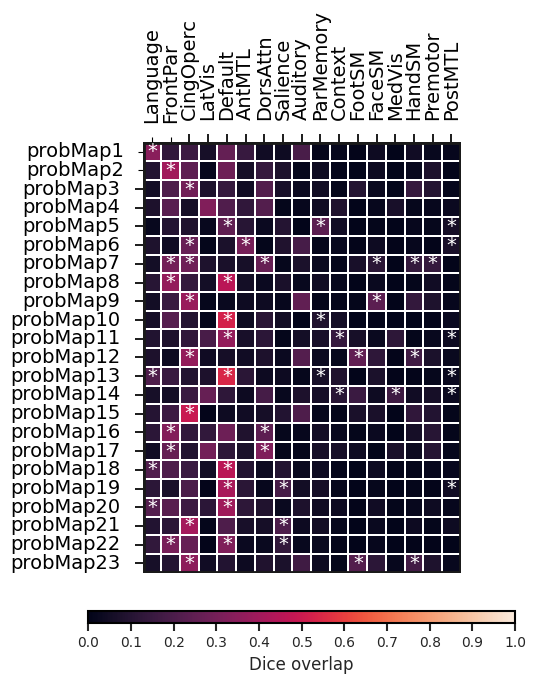

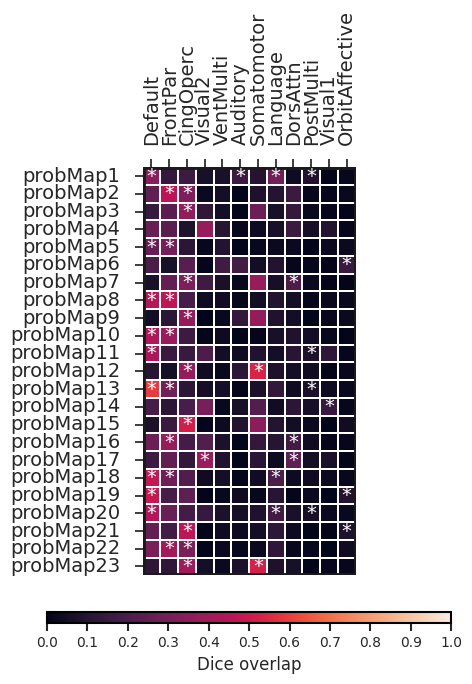

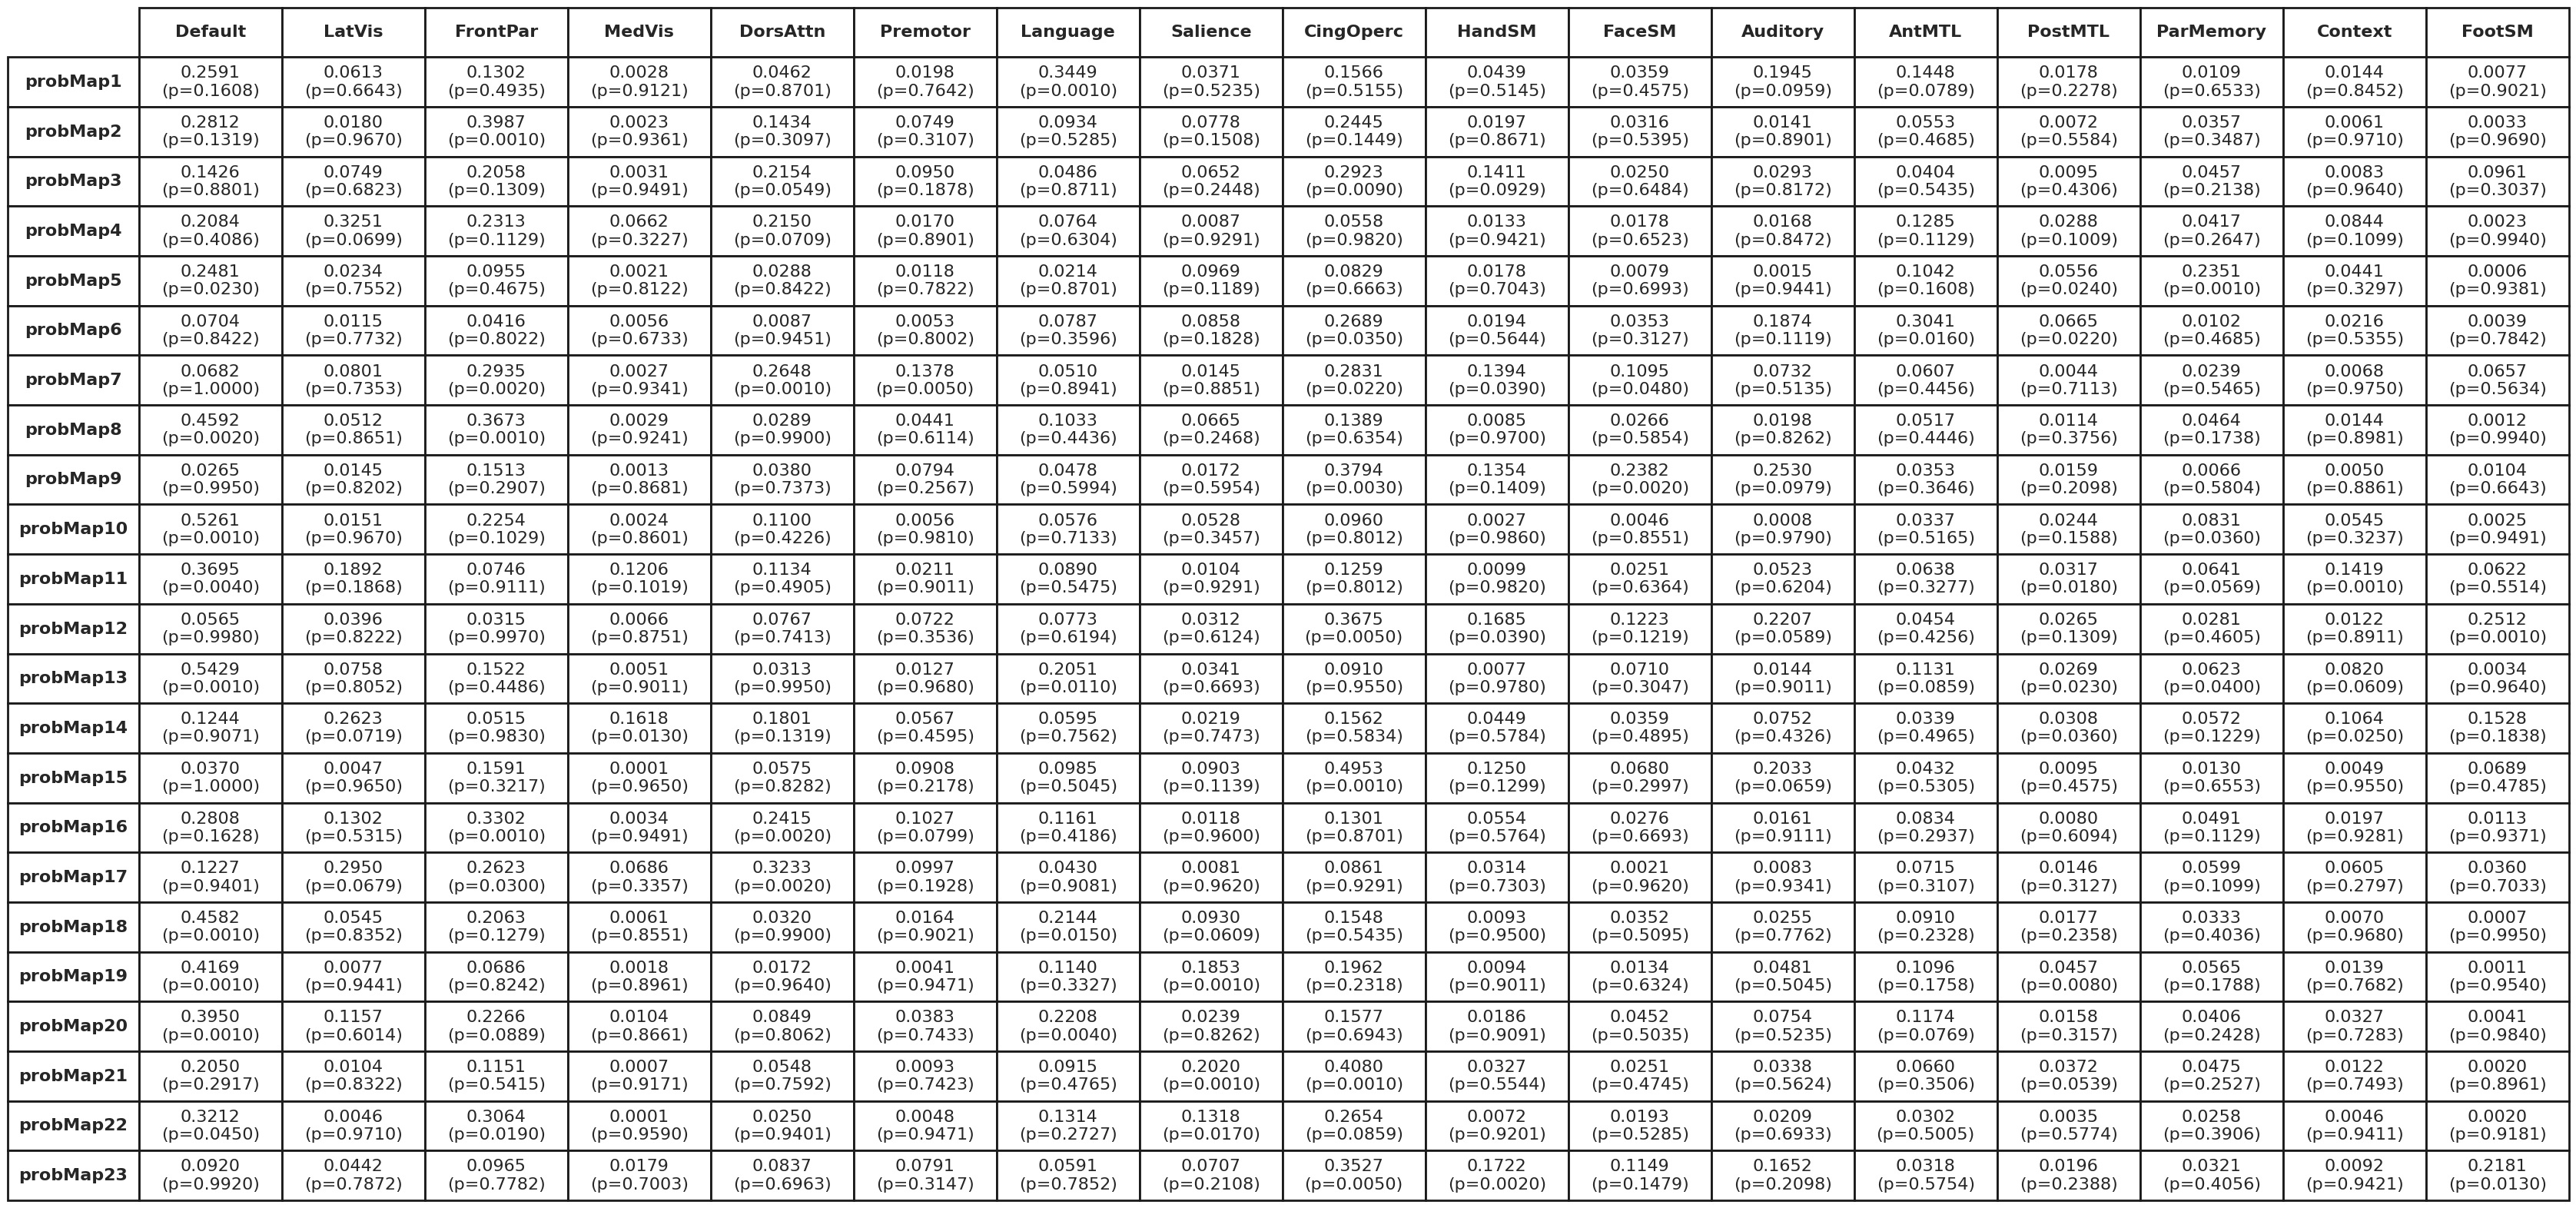

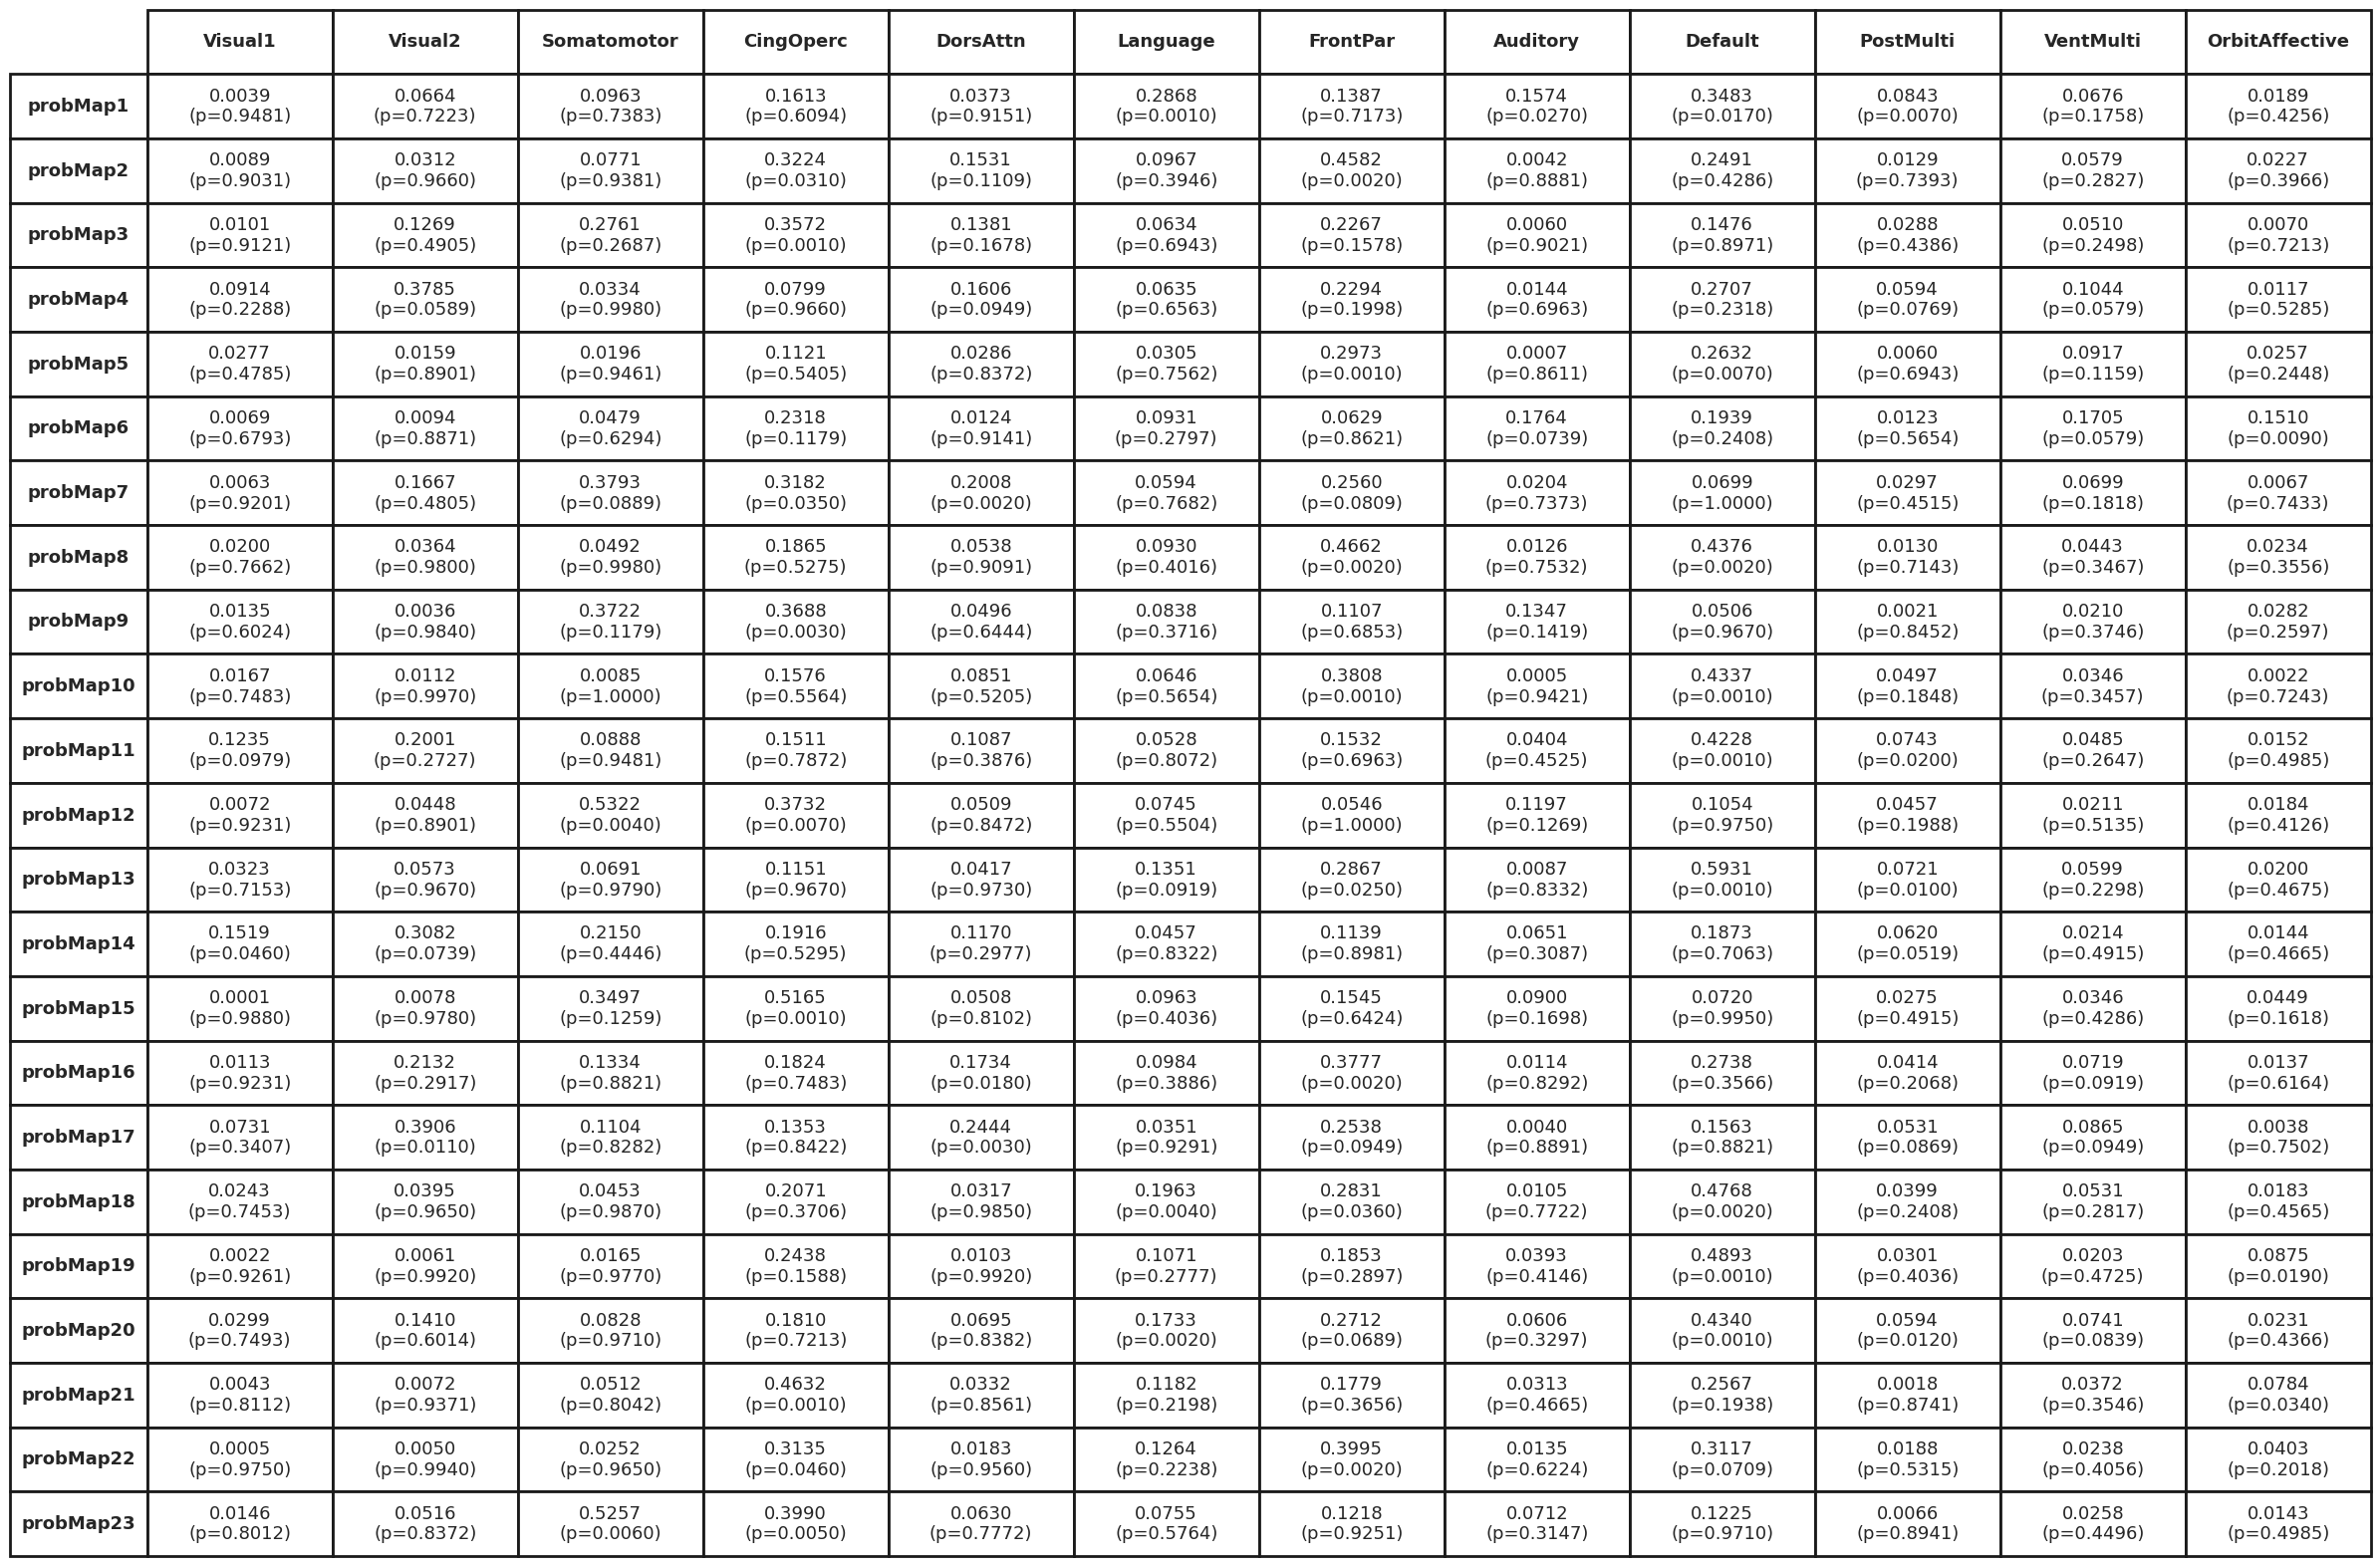

In [19]:
file_paths = [f'./data/prob_maps/probMap_network{i}.mat' for i in range(1, n_maps+1)]
network_labels = [f'probMap{i}' for i in range(1, n_maps+1)]

config = './data/configs/ProbMap_Network_config.ini'

atlas_names_list = ["EG17", "MG360J12"]

# construct DataParams object based on the data file path and config
ref_params = cnc.compute_overlap_with_atlases.DataParams(config, file_paths)
# compute the overlap with atlases and save the results
cnc.compute_overlap_with_atlases.network_correspondence(ref_params, atlas_names_list, "./results/probMaps", network_labels)